In [39]:
import math
import catboost
import colorama
import lightgbm
import hyperopt
import matplotlib
import numpy as np
import pandas as pd
import pickle as pkl
from time import time
import seaborn as sns
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind, mode
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from catboost import CatBoost, CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, mean_squared_error
from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

margin = ''.join([' ' for i in range(50)])
colorama.init()

#### Загрузка и базовый анализ датасета

In [40]:
data = pd.read_csv('data/train.csv')
print(data.shape)
data = data.join(pd.read_csv('data/y_train.csv'), how='left')
print(data.shape)
data.head(2)

(720000, 58)
(720000, 59)


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,y_train
0,"-131,97405146667",12.0,"13,0",11.747860,1.0,2.0,"22,0","-27,750277493704",9.0,NaN,...,3.0,"11,0",40.588345,16.957673,14.360604,"-53,415701398274706",NaN,NaN,-40.849368,1
1,"-48,3041715861774",9.0,"10,0",10.436009,1.0,NaN,"24,0","-25,703719919085497",8.0,0.0,...,2.0,NaN,27.113802,-61.457339,2.627029,"-39,6179932194784",24.686063,NaN,-45.108764,1


In [41]:
test = pd.read_csv('data/test.csv')
test['y_train'] = 2
print(test.shape)
test.head(2)

(180000, 59)


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,y_train
0,"-61,9235116483076",13.0,"12,0",42.495074,0.0,2.0,"23,0","-47,8252197312742",7.0,0.0,...,3.0,"14,0",13.830640,-64.612730,13.277488,"34,7084543042125",36.449271,28.157638,-35.043772,2
1,"90,3756709087014",13.0,NaN,-11.930282,NaN,3.0,"24,0","-61,582177706024105",7.0,0.0,...,2.0,"13,0",36.309616,11.365139,-9.356658,"-37,3715281054871",NaN,NaN,-3.067683,2


In [42]:
data = pd.concat([data, test], axis=0)
print(data.shape)
data.head(2)

(900000, 59)


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,y_train
0,"-131,97405146667",12.0,"13,0",11.747860,1.0,2.0,"22,0","-27,750277493704",9.0,NaN,...,3.0,"11,0",40.588345,16.957673,14.360604,"-53,415701398274706",NaN,NaN,-40.849368,1
1,"-48,3041715861774",9.0,"10,0",10.436009,1.0,NaN,"24,0","-25,703719919085497",8.0,0.0,...,2.0,NaN,27.113802,-61.457339,2.627029,"-39,6179932194784",24.686063,NaN,-45.108764,1


In [43]:
'''
приводим все поля к типу цифровому типу данных, что бы было удобнее с ними работать
'''
for c in data.columns:
    if data[c].dtype == 'O':
        data[c] = data[c].str.replace(',', '.').astype(float)

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900000 entries, 0 to 179999
Data columns (total 59 columns):
feature_1     820529 non-null float64
feature_2     808921 non-null float64
feature_3     831550 non-null float64
feature_4     828051 non-null float64
feature_5     819375 non-null float64
feature_6     796632 non-null float64
feature_7     791582 non-null float64
feature_8     796405 non-null float64
feature_9     840044 non-null float64
feature_10    794046 non-null float64
feature_11    792089 non-null float64
feature_12    822082 non-null float64
feature_13    801824 non-null float64
feature_14    822891 non-null float64
feature_15    785297 non-null float64
feature_16    822112 non-null float64
feature_17    804309 non-null float64
feature_18    807722 non-null float64
feature_19    857586 non-null float64
feature_20    829599 non-null float64
feature_21    803971 non-null float64
feature_22    813872 non-null float64
feature_23    768612 non-null float64
feature_24    8

In [45]:
data_stats = data.describe().T
data_stats

,count,mean,std,min,25%,50%,75%,max
feature_1,820529.0,11.012513,99.986889,-480.088690,-56.357813,11.029669,78.379658,545.896248
feature_2,808921.0,12.329729,0.796650,7.000000,12.000000,13.000000,13.000000,13.000000
feature_3,831550.0,11.344055,1.662548,3.000000,10.000000,11.000000,13.000000,15.000000
feature_4,828051.0,25.406132,20.636810,-72.310070,11.492726,25.421574,39.346755,128.900592
feature_5,819375.0,0.313465,0.536960,0.000000,0.000000,0.000000,1.000000,4.000000
feature_6,796632.0,2.180648,0.771303,0.000000,2.000000,2.000000,3.000000,3.000000
feature_7,791582.0,23.222268,0.867651,17.000000,23.000000,23.000000,24.000000,24.000000
feature_8,796405.0,-46.304667,19.875120,-138.181159,-59.736287,-46.305721,-32.910540,55.334255
feature_9,840044.0,7.901558,1.286734,1.000000,7.000000,8.000000,9.000000,10.000000
feature_10,794046.0,0.269151,0.443519,0.000000,0.000000,0.000000,1.000000,1.000000


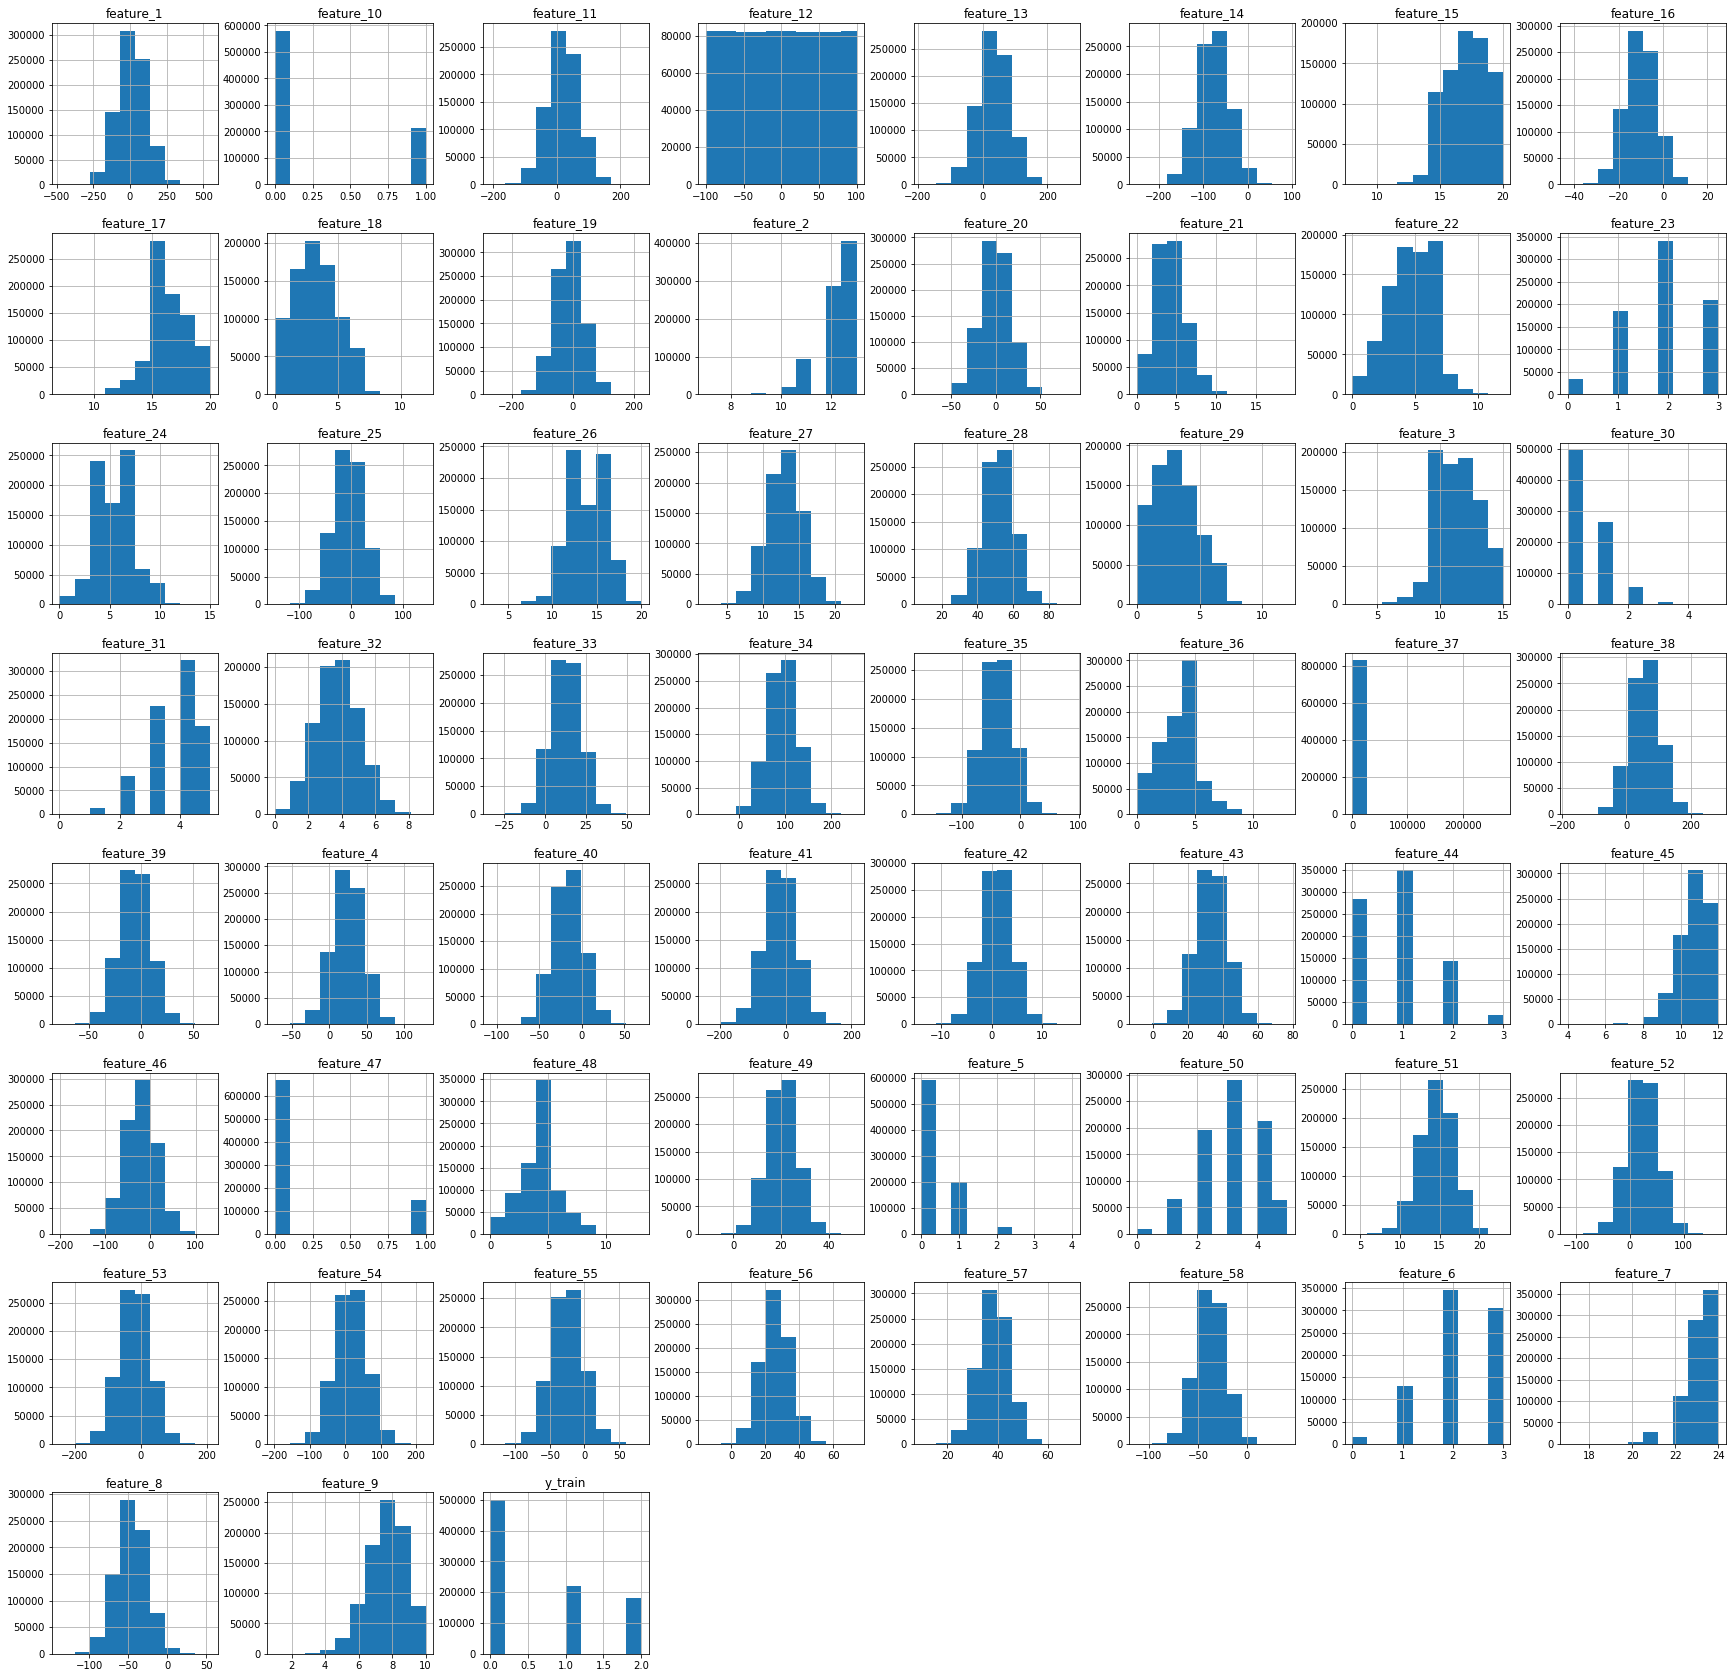

In [46]:
'''
смотрим распределения полей, что бы составить представление о характере имеющихся данных
для принятия решения о способе заполнения пропущенных значений
'''
matplotlib.rcParams['figure.figsize'] = (30, 30)
matplotlib.rcParams['font.size'] = (10)
data.hist()
plt.show()

In [47]:
'''
выбираем категориальные признаки
'''
cat_columns = [c for c in data.columns if (data[c].dropna().nunique() <= 20) and ('isnull' not in c) and (c != 'y_train')]
print(cat_columns)

['feature_2', 'feature_3', 'feature_5', 'feature_6', 'feature_7', 'feature_9', 'feature_10', 'feature_15', 'feature_17', 'feature_18', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_26', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_36', 'feature_44', 'feature_45', 'feature_47', 'feature_48', 'feature_50', 'feature_51']


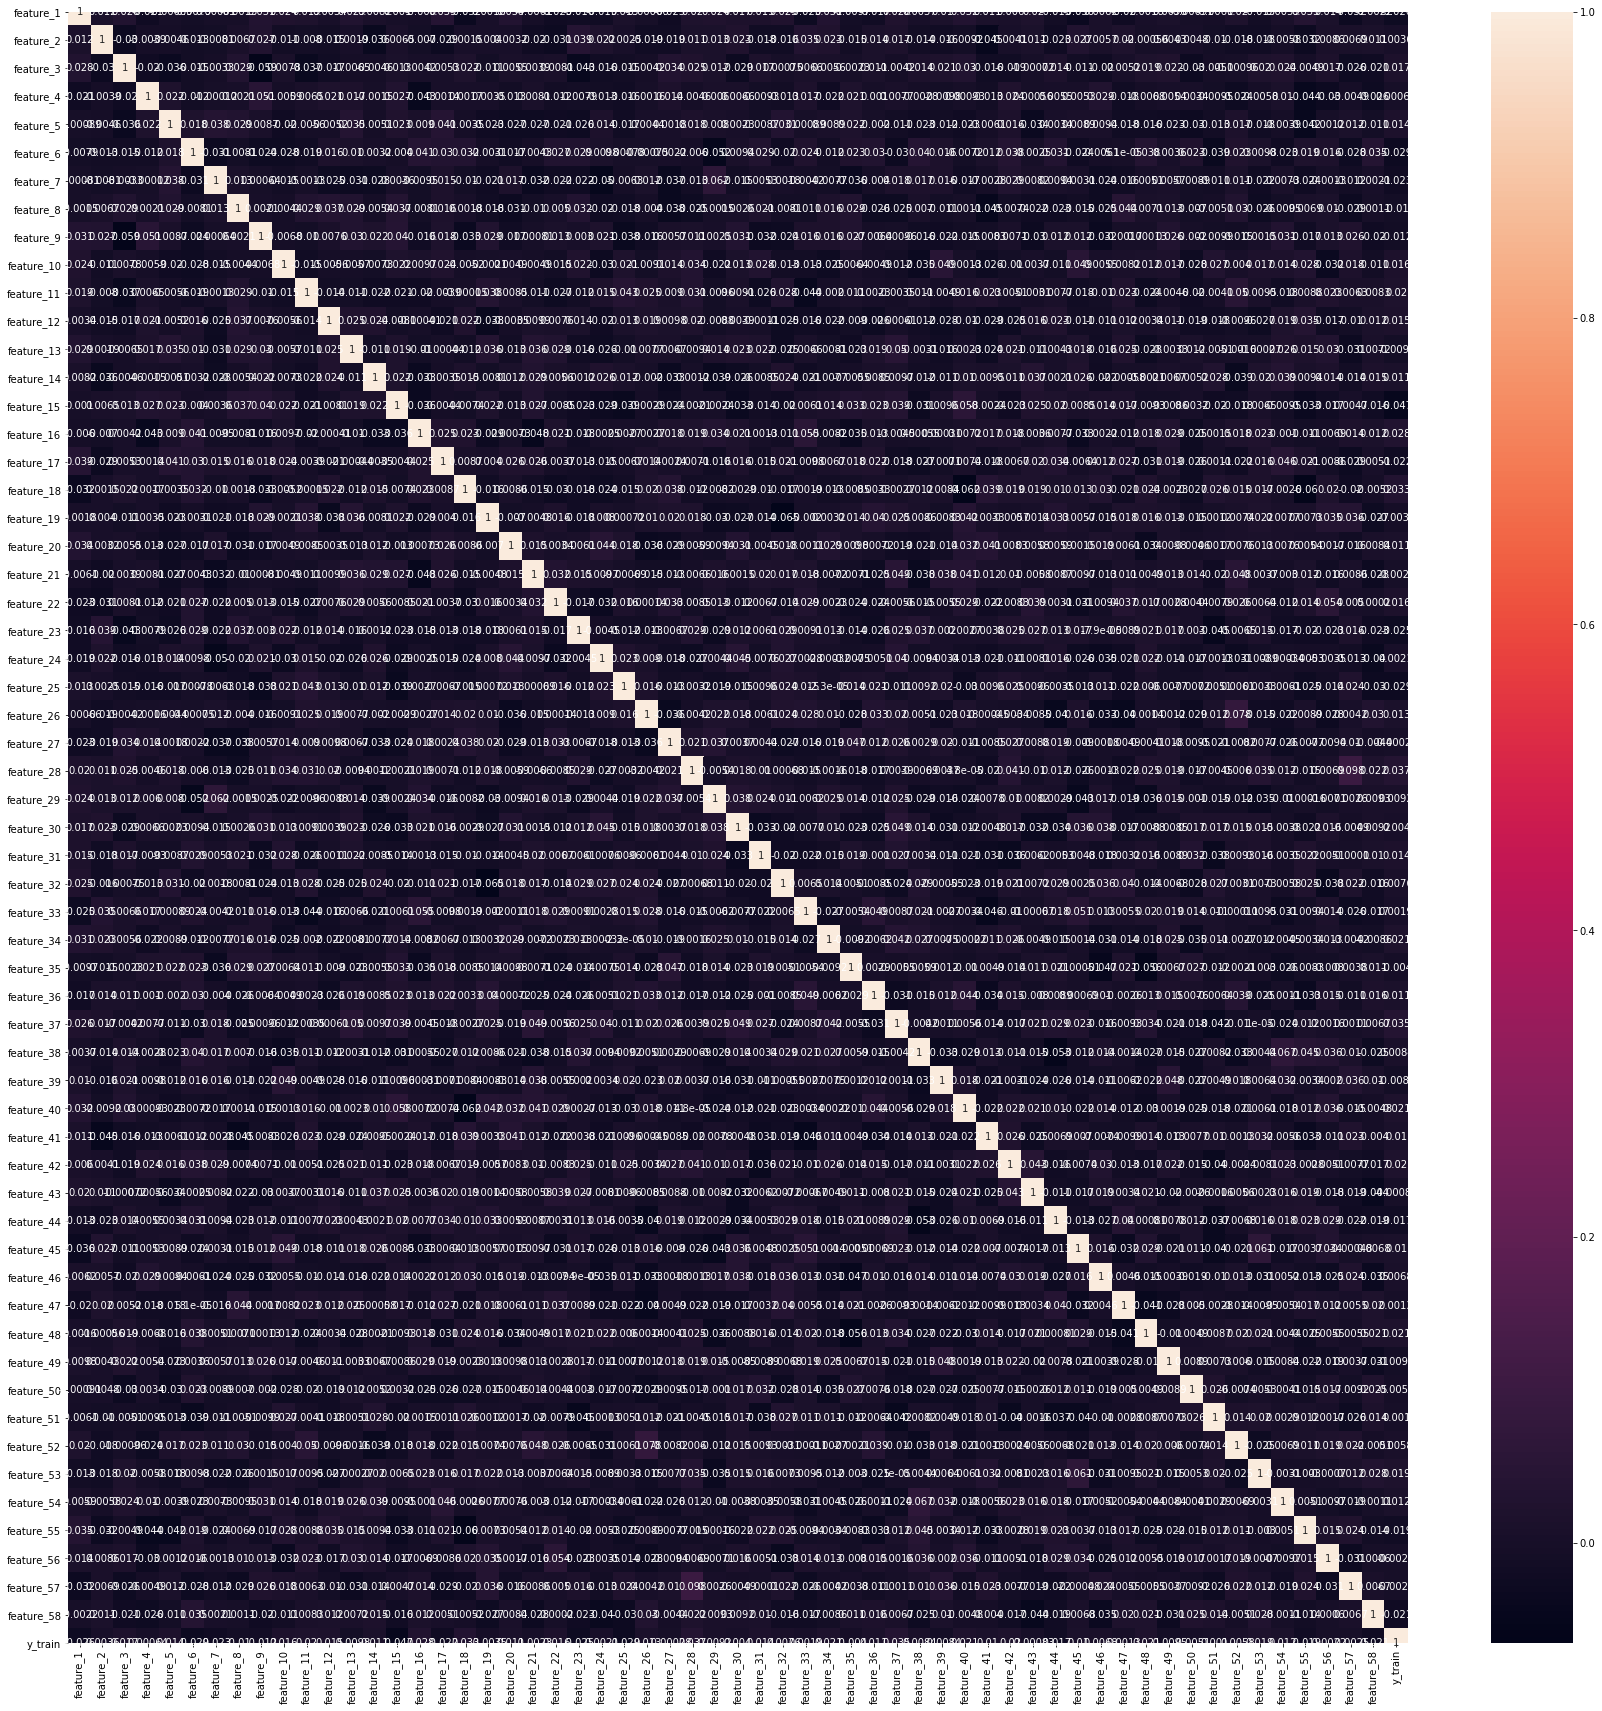

In [49]:
sns.heatmap(data.dropna().corr(), annot=True)
plt.show()

In [50]:
#как мы видим, интеркорреляций не наблюдается, заначит, что можно не беспокоиться о снижении размерностей 

part of 1st class: 30.67%


'\nнаблюдается перекос в предсказываемых классах.\nпредпринимались попытки компенсировать перекос при помощи уменьшения доминирующей выборки или семплирование\nмаленькой выборки при помощи SMOTE алгоритма\nни один из способов не дал существенного прироста качества обучения и я решил их не применять в силу\nлибо сокращения общего датасета в первом случае, либо большой вычислительной стоимости во втором.\n'

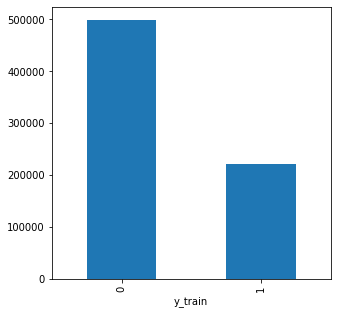

In [51]:
matplotlib.rcParams['figure.figsize'] = (5, 5)
data[data['y_train']<2].groupby('y_train').size().plot(kind='bar')
print('part of 1st class: {}%'.format(str(round(data[data['y_train']<2]['y_train'].mean()*100, 2))))
'''
наблюдается перекос в предсказываемых классах.
предпринимались попытки компенсировать перекос при помощи уменьшения доминирующей выборки или семплирование
маленькой выборки при помощи SMOTE алгоритма
ни один из способов не дал существенного прироста качества обучения и я решил их не применять в силу
либо сокращения общего датасета в первом случае, либо большой вычислительной стоимости во втором.
'''

#### Подготовка датасета к обучению

In [52]:
'''
заполняем пропущенные значения некоей константной величиной для категориальных переменных
и средним значением для непрерывных с сохранением информации о местах пропусков
(поле fieldname_isnull) это помогает при нахождении нелинейных зависимостей методом случайного леса

в процессе работы я пробовал несколько алгоритмов заполнения пропусков
'''
X = data.copy(deep=True)
for c in [c for c in X.columns if c != 'y_train']:
    X[f'{c}_isnull'] = X[c].isnull().astype(int)
    if c in cat_columns:
        X[c] = X[c].fillna(-1000)
    else:
        X[c] = X[c].fillna(X[c].dropna().mean())
test = X[X['y_train']==2].drop('y_train', axis=1)
X = X[X['y_train']<2]
print(X.shape, test.shape)
X.head(2)

(720000, 117) (180000, 116)


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_49_isnull,feature_50_isnull,feature_51_isnull,feature_52_isnull,feature_53_isnull,feature_54_isnull,feature_55_isnull,feature_56_isnull,feature_57_isnull,feature_58_isnull
0,-131.974051,12.0,13.0,11.747860,1.0,2.0,22.0,-27.750277,9.0,-1000.0,...,0,0,0,0,0,0,0,1,1,0
1,-48.304172,9.0,10.0,10.436009,1.0,-1000.0,24.0,-25.703720,8.0,0.0,...,0,0,1,0,0,0,0,0,1,0


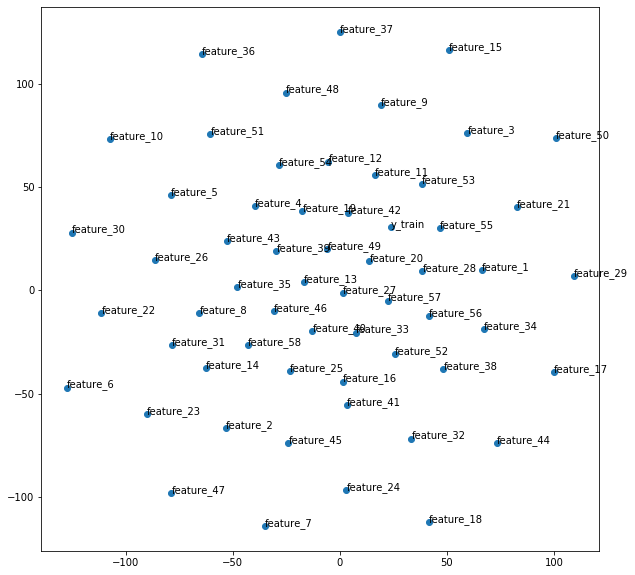

In [53]:
'''
тут я решил посмотреть на отношения между полями, что бы принять решение о возможном проведения факторного анализа для
извлечения дополнительных фичей.
на графике видно, что имеющиеся фичи не особенно группируются.
делать группировку в разрезе данных я не стал, т.к. это ресурсозатратно и, судя по интеркорреляциям, бессмысленно
'''
data_tsne = TSNE().fit_transform(X[[c for c in X.columns if ('isnull' not in c)]].T)
matplotlib.rcParams['figure.figsize'] = (10, 10)
plt.scatter(data_tsne[:,0], data_tsne[:,1])
for i, txt in enumerate([c for c in X.columns if ('isnull' not in c)]):
    plt.annotate(txt, (data_tsne[i, 0], data_tsne[i, 1]))
plt.show()

In [54]:
'''
делим датасет на выборки для тренировки, валидации и тестирования. стратификацию делаем только по целевому признаку,
по остальным категориальным признакам стратификация получается довольно плохо, это связано с очень низкими корреляциями между
признаками
'''
y = X['y_train']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.02, random_state=42, stratify=X['y_train'])
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.5, random_state=42, stratify=X_test['y_train'])
X_train.drop('y_train', axis=1, inplace=True)
X_test.drop('y_train', axis=1, inplace=True)
X_val.drop('y_train', axis=1, inplace=True)
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(705600, 116) (7200, 116) (7200, 116) (705600,) (7200,) (7200,)


In [82]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print(X_res.shape, y_res.shape)

(978338, 116) (978338,)


#### Построение моделей

In [83]:
'''
обучаем простейшую модель catboost_classifier и смотрим что получится

практика показала несостоятельность линейных моделей при обучении на текущем датасете
использование xgboost, lightgbm и catboost не показали польшой разницы в результатах
и я решил выбрать catboost за хорошее сочетание скорости и качества
'''
#_train = catboost.Pool(X_train, y_train)
_train = catboost.Pool(X_res, y_res)
_val = catboost.Pool(X_val, y_val)
model = CatBoostClassifier(iterations = 500, eval_metric='AUC', loss_function='Logloss', thread_count=-1,
                          random_seed=42, verbose=False)
model.fit(_train, eval_set=_val, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [84]:
'''
возьмём это значение за бейзлайн для дальнейшей работы
'''
roc_auc_score(y_test, model.predict(X_test))

0.6085214604236343

Для итоговой модели я решил использовать тот же фреймворк с небольшим тюнингом параметров при помощи hyperopt

In [85]:
def cat_objective(params):
    global cur_best_loss, cur_best_auc, cat_estimator

    _train = catboost.Pool(X_res, label=y_res)
    _val = catboost.Pool(X_val, label=y_val)
    
    model = CatBoostClassifier(iterations = 500,
                               early_stopping_rounds = 100,
                               loss_function='CrossEntropy',
                               boosting_type='Plain',
                               eval_metric='AUC',
                               learning_rate=params['learning_rate'],
                               depth=params['depth'],
                               min_data_in_leaf=params['min_data_in_leaf'],
                               l2_leaf_reg=params['l2_leaf_reg'],
                               max_bin=255,
                               task_type='GPU',
                               gpu_ram_part=.9,
                               thread_count=-1,
                               random_seed=42,
                               verbose=False)
    model.fit(_train, eval_set=_val)
    
    y_pred = model.predict(X_test)
    test_loss = model.get_best_score()['validation']['CrossEntropy']
    if np.isnan(test_loss):
        raise Exception('loss is nan')
    auc = roc_auc_score(y_test, y_pred)
    if auc>cur_best_auc:
        cat_estimator = model
        cur_best_auc = auc
        print(colorama.Fore.GREEN + 'NEW BEST AUC={}, LogLoss={}{}'.format(cur_best_auc,
                                                   test_loss, margin) + colorama.Fore.RESET, end='\r')
    return {'loss': test_loss, 'status': STATUS_OK}

In [ ]:
cat_params = {
    'learning_rate': hp.loguniform('learning_rate', -5.0, -2.3),
    'depth': hp.choice('depth', np.arange(1, 16, dtype=int)),
    'min_data_in_leaf': hp.quniform ('min_data_in_leaf', 1, 10, 1),
    'l2_leaf_reg': hyperopt.hp.quniform('l2_leaf_reg', 1, 10, 1)
}

cat_estimator = None
obj_call_count = 0
cur_best_loss = np.inf
cur_best_auc = -np.inf

trials = Trials()
best = hyperopt.fmin(fn=cat_objective,
                     space=cat_params,
                     algo=tpe.suggest,
                     max_evals=200,
                     trials=trials,
                     verbose=1)

NEW BEST AUC=0.5951348244147158, LogLoss=0.5487825520833334                                                                                                                        
NEW BEST AUC=0.6178799122073578, LogLoss=0.5250241427951389                                                                                                                        
  2%|██▋                                                                                                          | 5/200 [04:42<3:18:06, 60.96s/it, best loss: 0.5250241427951389]

In [79]:
with open(r'models/cat.pkl', 'wb') as f:
    pkl.dump(cat_estimator, f)

#### Создание файла сабмита

In [80]:
pred = cat_estimator.predict(test)
pd.Series(pred).to_csv('data/submittion.csv', index=None)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [81]:
pred.mean()

0.11562777777777777